### 迷宮遊戲玩法：起點為(1, 1)，終點為(4, 3)或(4, 2)，走到(4, 3)獎勵為1，走到(4, 2)獎勵為-1，每走一步獎勵均為-0.04

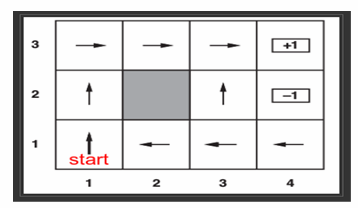

In [1]:
# 從IPython.display模組匯入Image類別，用來在Jupyter Notebook中顯示圖片
from IPython.display import Image

# 載入並顯示位於當前目錄中的maze.png圖片，設定寬度為300像素
Image('./maze.png', width = 300)

In [2]:
# 匯入相關套件(numpy、random)
import numpy as np
import random

In [3]:
# 定義網格世界的大小：3列 x 4行(類似棋盤的格子數)
ROW_COUNT, COLUMN_COUNT = 3, 4                 # 3列 x 4行

# 節點總數(每一個格子代表一個節點)
NODE_COUNT = ROW_COUNT * COLUMN_COUNT          # 3 * 4 = 12個節點

# 每移動一步的懲罰分數(鼓勵儘快到達終點)
NORMAL_REWARD = -0.04                          # 每走一步扣-0.04分

# 終點的正向獎勵
WIN_REWARD = 1                                 # 成功到達終點(4, 3)得1分

# 終點的負向獎勵(踩到失敗格)
LOSS_REWARD = -1                               # 踩到陷阱(4, 2)扣1分

# 得分終點的節點編號(右下角，對應格子位置為(3, 3)，節點編號為11)
WIN_TERMINAL = NODE_COUNT - 1                  # 12 - 1 = 11

# 失分終點的節點編號((3,2)，在終點左邊一格，節點編號為8)
LOSS_TERMINAL = NODE_COUNT - 1 - COLUMN_COUNT  # 12 - 1 - 4 = 7 -> 節點7

# 牆壁節點的編號(這些格子不可進入或通過)
WALL_NODES = [5]                               # 第5號節點是牆(對應格子位置為(2,2))

# 行動空間的定義：定義4個可能的移動方向
(UP, DOWN, LEFT, RIGHT) = range(4)             # 對應數字0, 1, 2, 3

In [4]:
# 建立一個名為x的串列(list)，裡面包含一些重複的整數
x = [0, 4, 0, 1, 2, 1, 0, 4, 0, 1, 2, 1, 2, 3, 7]

# 使用set()函數將串列x轉換成集合(set)，自動去除重複的元素
set(x)

{0, 1, 2, 3, 4, 7}

In [5]:
# 建立一個名為x的串列(list)，包含15個數字
x = [0, 4, 0, 1, 2, 1, 0, 4, 0, 1, 2, 1, 2, 3, 7]

# 使用reverse()方法反轉串列x的元素順序
x.reverse()

# 輸出反轉後的串列x
x

[7, 3, 2, 1, 2, 1, 0, 4, 0, 1, 2, 1, 0, 4, 0]

In [6]:
# 環境類別(模擬一個網格世界的環境)
class Environment():
    
    # 初始化方法，在建立物件時呼叫
    def __init__(self):
        # 初始化每個節點的狀態值(State Value Function)，預設為0.0
        self.state_value = np.full(NODE_COUNT, 0.0)

        # 記錄每個節點被更新的次數，用來計算平均值
        self.state_value_count = np.full(NODE_COUNT, 0)
        
    # 重置環境到初始狀態
    def reset(self):
        self.position = 0                  # 玩家初始位置設為節點0
        self.trajectory = [self.position]  # 建立行動軌跡，紀錄每次經過的節點

    # 取得所有可能的狀態(節點編號0到NODE_COUNT - 1)
    def get_states(self):
        return [i for i in range(NODE_COUNT)]

    # 取得所有可能的行動(上、下、左、右)
    def get_actions(self):  
        return [UP, DOWN, LEFT, RIGHT]

    # 檢查遊戲是否結束(是否抵達終點或陷阱)
    def is_done(self):
        return self.position == WIN_TERMINAL or self.position == LOSS_TERMINAL
    
    # 根據玩家執行的行動，更新位置
    def update_position(self, action):
        if action == DOWN:
            new_position = self.position - COLUMN_COUNT  # 往下走，列數減一
        if action == UP:
            new_position = self.position + COLUMN_COUNT  # 往上走，列數加一
        if action == LEFT:
            new_position = self.position - 1             # 往左走，節點編號減一
        if action == RIGHT:
            new_position = self.position + 1             # 往右走，節點編號加一
            
        # 邊界檢查：如果超出地圖或撞到牆，就不移動
        if new_position < 0 or new_position>= NODE_COUNT \
            or new_position in WALL_NODES: 
            return self.position

        return new_position
    
    # 執行一步動作
    def step(self, action):
        # 如果已經結束，不能再移動
        if self.is_done():
            raise Exception("Game over")
        
        # 嘗試移動位置
        self.position = self.update_position(action)

        # 將新位置加入軌跡中
        self.trajectory.append(self.position)        

        # 根據目前位置給予對應的獎勵
        if self.position == WIN_TERMINAL:
            reward = WIN_REWARD
        elif self.position == LOSS_TERMINAL:
            reward = LOSS_REWARD
        else:    
            reward = NORMAL_REWARD

        # 回傳當前狀態與獎勵
        return self.position, reward

    # 更新每個狀態的預期價值(基於一條軌跡)
    def update_state_value(self, final_value):
        # 使用First-Visit Monte Carlo方法：每個節點只更新第一次出現的價值
        # 取得這條軌跡中曾經出現過的不同節點
        distinct_node_list = list(set(self.trajectory))

        # 建立一個臨時的狀態價值陣列，對應這些節點
        distinct_state_value = np.full(len(distinct_node_list), 0.0)

        # 將軌跡倒序，從終點回推
        reverse_trajectory = self.trajectory.copy()
        reverse_trajectory.reverse()

        # 倒推每個節點的狀態值
        for i in reverse_trajectory:
            final_value += NORMAL_REWARD               # 每往回一步都會扣移動成本
            index = distinct_node_list.index(i)        # 取得節點在distinct_node_list中的索引
            distinct_state_value[index] = final_value  # 將對應的狀態值儲存下來

        # 將這些狀態值加總到總體狀態值中，並更新次數
        for index, val in enumerate(distinct_node_list):
            self.state_value[val] += distinct_state_value[index] 
            self.state_value_count[val] += 1        
                
    # 回傳目前的狀態值函數期望值(平均值)
    def get_observation(self):
        mean1 = np.full(NODE_COUNT, 0.0)
        for i in range(NODE_COUNT):
            if self.state_value_count[i] == 0: 
                mean1[i] = 0
            else:
                mean1[i] = self.state_value[i] / self.state_value_count[i]
        return mean1

In [7]:
# 代理人類別(Agent)，負責根據狀態值選擇最佳行動
class Agent():
    
    # 初始化方法(目前沒做任何設定)
    def __init__(self):
        pass

    # 檢查代理人在目前位置可以採取哪些合法行動
    def check_possible_action(self, env):
        # 取得所有基本方向行動
        possible_actions = env.get_actions()

        # 簡化程式碼，將目前位置儲存在變數中
        pos = env.position

        # 邊界條件：避免走出網格範圍
        if pos < COLUMN_COUNT:                      # 最下方一列，不可往下
            possible_actions.remove(DOWN)
        if pos % COLUMN_COUNT == 0:                 # 最左邊一行，不可往左
            possible_actions.remove(LEFT)
        if pos >= NODE_COUNT - COLUMN_COUNT:        # 最上方一列，不可往上
            possible_actions.remove(UP)
        if pos % COLUMN_COUNT == COLUMN_COUNT - 1:  # 最右邊一行，不可往右
            possible_actions.remove(RIGHT)

        # 牆壁條件：避免撞牆
        if pos - 1 in WALL_NODES and LEFT in possible_actions:
            possible_actions.remove(LEFT)
        if pos + 1 in WALL_NODES and RIGHT in possible_actions:
            possible_actions.remove(RIGHT)
        if pos + COLUMN_COUNT in WALL_NODES and UP in possible_actions:
            possible_actions.remove(UP)
        if pos - COLUMN_COUNT in WALL_NODES and DOWN in possible_actions:
            possible_actions.remove(DOWN)

        return possible_actions

    # 選擇下一步行動
    def action(self, env):
        # 取得目前所有狀態的期望狀態值
        state_value = env.get_observation()

        max_value = -999       # 儲存目前找到的最大狀態值
        next_action_list = []  # 儲存具有最大狀態值的所有行動
        possible_actions = self.check_possible_action(env)

        # 找出目前狀態可移動位置中，狀態值最大的行動
        for i in possible_actions:
            new_pos = env.update_position(i)
            value = state_value[new_pos]

            if value > max_value:
                max_value = value
                next_action_list = [i]
            elif value == max_value:
                next_action_list.append(i)

        # 根據最大值行動清單來決定下一步
        if len(next_action_list) == 0:
            # 如果沒有最大值，隨機選擇行動
            next_action = random.choice(possible_actions)
        else:
            # 多個最佳行動，隨機抽選其中之一
            next_action = random.choice(next_action_list)

        new_position = env.update_position(next_action)

        # 防止陷入循環：檢查是否在來回走相同路線
        while (
            len(possible_actions) > 1 and 
            len(env.trajectory) >= 4 and
            new_position == env.trajectory[-2] and 
            new_position == env.trajectory[-4]
        ):
            # 移除會導致循環的行動，重新抽選其他方向
            possible_actions.remove(next_action)
            next_action = random.choice(possible_actions)
            new_position = env.update_position(next_action)

        return next_action

In [8]:
# 建立實驗：初始化環境與代理人
env = Environment()
agent = Agent()

# 用來儲存每一回合的總報酬(total reward)
total_reward_list = []

# 控制變數
no = 0         # 總共執行的回合數
done_no = 0    # 成功結束(到達終點或陷阱)的回合數

# 最多執行100回合，若已成功完成41回合也會提前結束
while no < 100 and done_no < 41:
    no += 1
    env.reset()           # 每回合開始前重置環境
    total_reward = 0      # 重置該回合的報酬
    action_count = 0      # 行動步數累計

    # 回合未結束就持續行動
    while not env.is_done():
        # 代理人選擇行動
        action = agent.action(env)
        action_count += 1

        # 執行行動並更新環境
        state, reward = env.step(action)

        # 累加報酬
        total_reward += reward

        # 防止無窮迴圈：如果行動超過100步仍未結束，強制結束回合
        if action_count > 100:
            env.position = 0  # 重置位置(避免無限循環)
            break

    # 印出本回合的行動軌跡
    print('trajectory', done_no, ':', env.trajectory)

    # 若成功走完(即沒超過100步)，才更新狀態值函數
    if action_count <= 100:
        env.update_state_value(total_reward)              # 更新狀態值
        total_reward_list.append(round(total_reward, 2))  # 記錄總報酬
        done_no += 1

    # 註解的程式碼可用於顯示狀態值函數的視覺化
    # state_value = np.around(env.get_observation().reshape(ROW_COUNT, COLUMN_COUNT), 2)
    # print(f"state value:\n{np.flip(state_value, axis = 0)}")  # 翻轉列，符合圖片顯示方向

# 顯示所有回合的總報酬(最多41筆)
print(f"累計報酬: {total_reward_list}")

trajectory 0 : [0, 4, 0, 4, 8, 9, 10, 6, 10, 6, 7]
trajectory 1 : [0, 1, 2, 1, 2, 3, 7]
trajectory 2 : [0, 1, 2, 3, 7]
trajectory 3 : [0, 1, 2, 3, 7]
trajectory 4 : [0, 1, 2, 3, 7]
trajectory 5 : [0, 1, 2, 3, 7]
trajectory 6 : [0, 1, 2, 3, 7]
trajectory 7 : [0, 1, 2, 3, 7]
trajectory 8 : [0, 1, 2, 3, 7]
trajectory 9 : [0, 1, 2, 3, 7]
trajectory 10 : [0, 1, 2, 3, 7]
trajectory 11 : [0, 1, 2, 3, 7]
trajectory 12 : [0, 1, 2, 3, 7]
trajectory 13 : [0, 1, 2, 3, 7]
trajectory 14 : [0, 1, 2, 3, 7]
trajectory 15 : [0, 1, 2, 3, 7]
trajectory 16 : [0, 1, 2, 3, 7]
trajectory 17 : [0, 1, 2, 3, 7]
trajectory 18 : [0, 1, 2, 3, 7]
trajectory 19 : [0, 1, 2, 3, 7]
trajectory 20 : [0, 1, 2, 3, 7]
trajectory 21 : [0, 1, 2, 3, 7]
trajectory 22 : [0, 1, 2, 3, 7]
trajectory 23 : [0, 1, 2, 3, 7]
trajectory 24 : [0, 1, 2, 3, 7]
trajectory 25 : [0, 1, 2, 3, 7]
trajectory 26 : [0, 1, 2, 3, 7]
trajectory 27 : [0, 1, 2, 3, 7]
trajectory 28 : [0, 1, 2, 3, 7]
trajectory 29 : [0, 1, 2, 3, 7]
trajectory 30 : [0, 1, 2

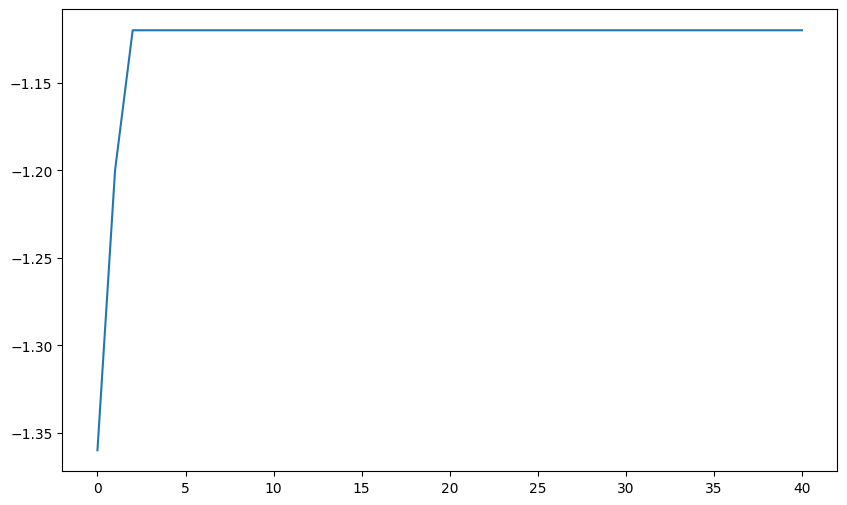

In [9]:
# 匯入繪圖套件(matplotlib)
import matplotlib.pyplot as plt

# 建立一個10x6吋大小的畫布
plt.figure(figsize = (10, 6))

# 繪製累計報酬列表的折線圖
plt.plot(total_reward_list)

In [10]:
# 取得目前環境中各節點的平均狀態值(state value)陣列
env.get_observation()

array([-1.33560976, -1.284     , -1.244     , -1.202     , -1.76      ,
        0.        , -1.52      , -1.16780488, -1.64      , -1.6       ,
       -1.56      ,  0.        ])